In [2]:
import os
import cv2
import time
import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from torch import nn
import torch.nn.functional as F
from pathlib import Path

In [3]:
torch.manual_seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

RAW_IMAGES = "./train/images"
RAW_MASKS = "./train/masks"
PATCH_IMAGES_DIR = "./train_patched/images"
PATCH_MASKS_DIR = "./train_patched/masks"
os.makedirs(PATCH_IMAGES_DIR, exist_ok=True)
os.makedirs(PATCH_MASKS_DIR, exist_ok=True)

In [4]:
all_files = sorted([os.path.splitext(f)[0] for f in os.listdir(RAW_IMAGES)])
x_temp, x_test = train_test_split(all_files, test_size=0.10, random_state=42)
x_train, x_val = train_test_split(x_temp, test_size=0.10, random_state=42)

split_sets = {
    "train": x_train,
    "val": x_val,
    "test": x_test
}

In [5]:
def create_tiles(img, mask, size=256, threshold=0.01, min_classes=2):
    img_tensor = torch.from_numpy(img).permute(2, 0, 1)
    mask_tensor = torch.from_numpy(mask)
    img_patches = img_tensor.unfold(1, size, size).unfold(2, size, size)
    img_patches = img_patches.contiguous().view(3, -1, size, size).permute(1, 0, 2, 3)
    mask_patches = mask_tensor.unfold(0, size, size).unfold(1, size, size)
    mask_patches = mask_patches.contiguous().view(-1, size, size)

    keep_indices = []
    for i, patch in enumerate(mask_patches):
        unique_classes = torch.unique(patch)
        fg_ratio = (patch != 0).float().mean().item()
        if len(unique_classes) >= min_classes or fg_ratio > threshold or np.random.rand() < 0.1:
            keep_indices.append(i)

    if not keep_indices:
        keep_indices.append(np.random.randint(0, len(img_patches)))

    return img_patches[keep_indices], mask_patches[keep_indices]


def preprocess_and_save_patches():
    for split_name, file_list in split_sets.items():
        out_img_dir = f"{PATCH_IMAGES_DIR}_{split_name}"
        out_mask_dir = f"{PATCH_MASKS_DIR}_{split_name}"
        os.makedirs(out_img_dir, exist_ok=True)
        os.makedirs(out_mask_dir, exist_ok=True)

        if os.listdir(out_img_dir):
            print(f"Skipping {split_name} (already processed)")
            continue

        print(f"Processing {split_name} split ({len(file_list)} images)...")
        for filename in tqdm(file_list):
            img_path = os.path.join(RAW_IMAGES, f"{filename}.jpg")
            mask_path = os.path.join(RAW_MASKS, f"{filename}_mask.png")

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img.shape[:2] != mask.shape[:2]:
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            img_patches, mask_patches = create_tiles(img, mask)

            for i in range(len(img_patches)):
                patch_img_np = img_patches[i].permute(1, 2, 0).numpy()
                patch_mask_np = mask_patches[i].numpy()
                cv2.imwrite(os.path.join(out_img_dir, f"{filename}_{i}.png"),
                            cv2.cvtColor(patch_img_np, cv2.COLOR_RGB2BGR))
                cv2.imwrite(os.path.join(out_mask_dir, f"{filename}_{i}_mask.png"), patch_mask_np)

preprocess_and_save_patches()


Processing train split (708 images)...


100%|██████████| 708/708 [00:32<00:00, 21.73it/s]


Processing val split (79 images)...


100%|██████████| 79/79 [00:03<00:00, 23.31it/s]


Processing test split (88 images)...


100%|██████████| 88/88 [00:03<00:00, 24.24it/s]


In [6]:
class PorosityDataset(Dataset):
    def __init__(self, image_dir, mask_dir, mean, std, transform=None):
        self.img_dir = image_dir
        self.mask_dir = mask_dir
        self.img_files = sorted(os.listdir(image_dir))
        self.mean = mean
        self.std = std
        self.transform = transform

    def __len__(self): return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        mask_name = os.path.splitext(img_name)[0] + "_mask.png"
        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        return img, mask

In [7]:
def compute_mean_std(image_dir):
    imgs = sorted(os.listdir(image_dir))
    mean, std = np.zeros(3), np.zeros(3)
    for img_name in tqdm(imgs[:200], desc="Computing mean/std (sampled 200)"):
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        mean += img.mean(axis=(0,1))
        std += img.std(axis=(0,1))
    mean /= len(imgs[:200])
    std /= len(imgs[:200])
    return mean.tolist(), std.tolist()

train_img_dir = f"{PATCH_IMAGES_DIR}_train"
train_mask_dir = f"{PATCH_MASKS_DIR}_train"
mean, std = compute_mean_std(train_img_dir)
print("Dataset mean/std:", mean, std)

Computing mean/std (sampled 200): 100%|██████████| 200/200 [00:01<00:00, 179.47it/s]

Dataset mean/std: [0.7784654346538497, 0.7163419901528546, 0.7100731614055142] [0.023226089936721782, 0.022259307085786714, 0.02296914216197023]


In [8]:
t_train = A.Compose([
    A.HorizontalFlip(), A.VerticalFlip(),
    A.RandomBrightnessContrast(0.2, 0.2),
    A.GridDistortion(p=0.2),
    A.GaussNoise(p=0.2)
])
t_val = A.Compose([])

train_dataset = PorosityDataset(train_img_dir, train_mask_dir, mean, std, t_train)
val_dataset = PorosityDataset(f"{PATCH_IMAGES_DIR}_val", f"{PATCH_MASKS_DIR}_val", mean, std, t_val)
test_dataset = PorosityDataset(f"{PATCH_IMAGES_DIR}_test", f"{PATCH_MASKS_DIR}_test", mean, std, t_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [9]:
def get_class_weights_from_masks(mask_dir, num_classes=6):
    class_counts = np.zeros(num_classes, dtype=np.int64)
    total = 0
    for mask_name in os.listdir(mask_dir):
        mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        total += mask.size
        for c in range(num_classes):
            class_counts[c] += np.sum(mask == c)
    freqs = class_counts / total
    freqs[freqs == 0] = 1e-6
    weights = 1 / freqs
    weights = weights * (num_classes / np.sum(weights))
    return torch.tensor(weights, dtype=torch.float32)

class_weights = get_class_weights_from_masks(train_mask_dir, num_classes=6).to(device)
print("Class weights:", class_weights)

Class weights: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_tensor_str.py:154: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:452.)
  nonzero_finite_vals = torch.masked_select(


tensor([1.6732e-03, 5.3105e-01, 5.3177e-01, 8.3160e-03, 3.4276e+00, 1.4996e+00],
       device='mps:0')


In [10]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,
)
model.to(device)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
class DiceFocalLoss(nn.Module):
    def __init__(self, n_classes, weight=None, gamma=2, alpha=0.5, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.focal = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
        self.n_classes = n_classes

    def forward(self, input, target):
        ce = self.focal(input, target)
        input_soft = F.softmax(input, dim=1)
        target_onehot = F.one_hot(target, num_classes=self.n_classes).permute(0,3,1,2)
        intersection = torch.sum(input_soft * target_onehot)
        dice = (2 * intersection + 1e-6) / (torch.sum(input_soft) + torch.sum(target_onehot) + 1e-6)
        return self.alpha * ce + (1 - self.alpha) * (1 - dice)

criterion = DiceFocalLoss(n_classes=6, weight=class_weights)

optimizer = torch.optim.AdamW([
    {"params": model.encoder.parameters(), "lr": 1e-4},  # slow LR for pretrained encoder
    {"params": model.decoder.parameters(), "lr": 1e-3},  # faster LR for decoder
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                                steps_per_epoch=len(train_loader),
                                                epochs=50)

In [12]:
def fit(model, train_loader, val_loader, epochs=50):
    best_val = np.inf
    freeze_until = 5  # freeze encoder for first 5 epochs
    for epoch in range(epochs):
        model.train()
        if epoch < freeze_until:
            for p in model.encoder.parameters():
                p.requires_grad = False
        else:
            for p in model.encoder.parameters():
                p.requires_grad = True

        train_loss, val_loss = 0, 0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} train"):
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} val"):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}: train={train_loss/len(train_loader):.4f}, val={val_loss/len(val_loader):.4f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_transfer_unet.pt")
            print("✅ Saved new best model")

fit(model, train_loader, val_loader, epochs=50)
print("Training complete.")

Epoch 1 train:  41%|████▏     | 72/174 [09:26<08:43,  5.13s/it] 

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
t_train = A.Compose([A.VerticalFlip(), A.HorizontalFlip(), A.GridDistortion(p=0.2),
                     A.GaussNoise(), A.RandomBrightnessContrast((0, 0.5), (0, 0.5))])
t_val = A.Compose([A.HorizontalFlip(), A.GridDistortion(p=0.2)])

In [ ]:
x_all_patches = sorted(os.listdir(PATCH_IMAGES_DIR))
x_temp, x_test = train_test_split(x_all_patches, test_size=0.10, random_state=42)
x_train, x_val = train_test_split(x_temp, test_size=0.10, random_state=42)

In [ ]:
train_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_train, mean, std, t_train)
val_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_val, mean, std, t_val)
test_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_test, mean, std, t_val)

In [ ]:
batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
def get_class_distribution(dataset, num_classes=6):
    class_counts = np.zeros(num_classes, dtype=int)
    for _, mask in DataLoader(dataset, batch_size=1):
        for m in mask:
            for cls in range(num_classes):
                class_counts[cls] += torch.sum(m == cls).item()
    return class_counts

train_class_counts = get_class_distribution(train_dataset)
val_class_counts = get_class_distribution(val_dataset)

print("Train class distribution:", train_class_counts)
print("Val class distribution:", val_class_counts)

Train class distribution: [148923074    327874    477657         0     82728    163245]
Val class distribution: [16662064    86990     3901        0     9404    17008]


In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,
)

In [ ]:
def get_class_weights_from_masks(
    masks_dir, 
    num_classes=6, 
    background_class_id=0, 
    background_weight_multiplier=0.01,
):
    class_counts = np.zeros(num_classes, dtype=np.int64)
    total_pixels = 0

    for mask_name in os.listdir(masks_dir):
        if mask_name.endswith(".png"):
            mask_path = os.path.join(masks_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if mask is not None:
                total_pixels += mask.size
                for cls in range(num_classes):
                    class_counts[cls] += np.sum(mask == cls)
    
    class_frequencies = class_counts / total_pixels
    class_frequencies[class_frequencies == 0] = 1e-6
    
    class_weights = 5.0 / class_frequencies
    
    class_weights[background_class_id] *= background_weight_multiplier
    
    class_weights = class_weights * (num_classes / np.sum(class_weights))
    
    return torch.tensor(class_weights, dtype=torch.float32)

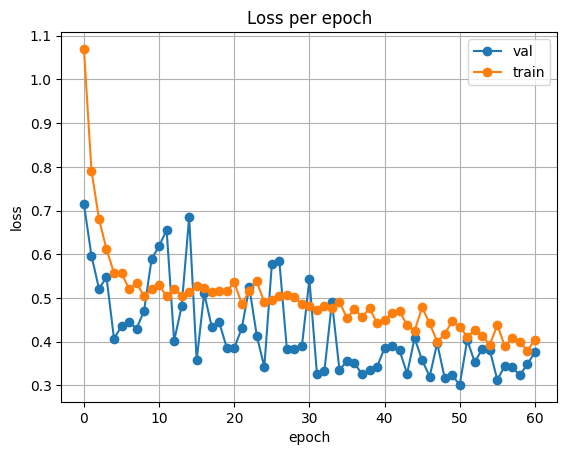

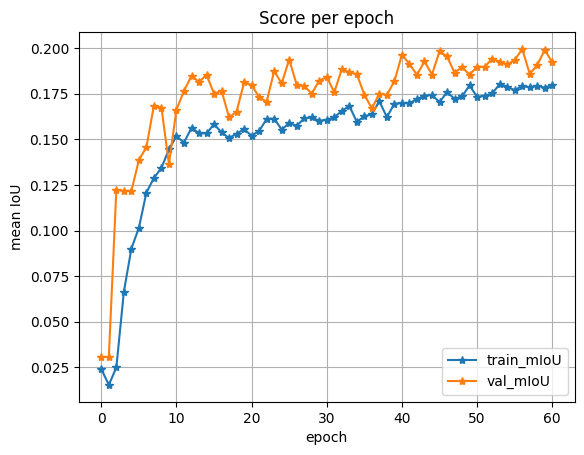

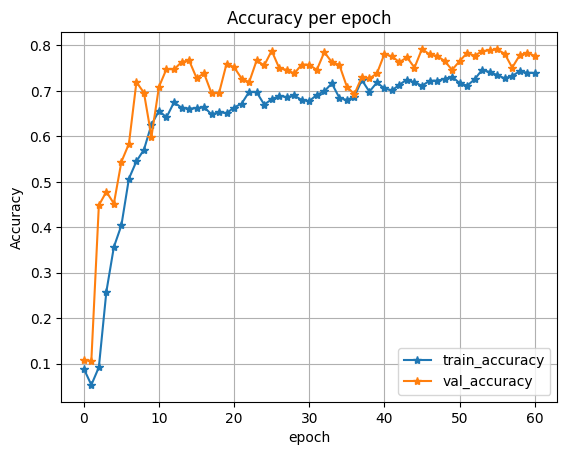

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
CLASS_COLORS = [
    [0, 0, 0],         # Class 0: Background
    [255, 0, 0],       # Class 1
    [0, 255, 0],       # Class 2
    [0, 0, 0],         # Class 3 (part of background)
    [255, 255, 0],     # Class 4
    [0, 255, 255],     # Class 5
]

In [ ]:
def evaluate_model(model, loader, device, num_classes):
    """
    Calculates the test mIOU, pixel accuracy, and loss.
    """
    print("Evaluating model...")
    model.eval()
    
    total_iou = 0.0
    total_accuracy = 0.0
    total_loss = 0.0
    
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluation"):
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate pixel accuracy
            correct = (preds == masks).sum().item()
            total = masks.nelement()
            total_accuracy += correct / total
            
            # Calculate IoU for each class and then the mean
            iou_per_batch = 0.0
            for cls in range(num_classes):
                pred_inds = preds == cls
                target_inds = masks == cls
                intersection = (pred_inds[target_inds]).long().sum().item()
                union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
                if union == 0:
                    iou_per_batch += 1.0 # If there is no ground truth or prediction for this class, score is 1
                else:
                    iou_per_batch += intersection / union
            total_iou += iou_per_batch / num_classes
            
    avg_loss = total_loss / len(loader)
    avg_accuracy = total_accuracy / len(loader)
    avg_iou = total_iou / len(loader)
    
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"Test mIOU: {avg_iou:.4f}")

In [ ]:
def masks_to_color_img(mask, class_colors):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in enumerate(class_colors):
        color_mask[mask == class_id] = color
    return color_mask

def save_and_display_predictions(model, loader, device, output_dir="test_predictions"):
    print(f"Saving prediction images to '{output_dir}/'...")
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    file_counter = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Generating Predictions"):
            images = images.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            images_cpu = images.cpu()
            masks_cpu = masks.cpu().numpy()
            preds_cpu = preds.cpu().numpy()

            for i in range(images_cpu.size(0)):
                img_np = images_cpu[i].numpy().transpose(1, 2, 0)
                img_np = (img_np * std + mean)
                img_np = np.clip(img_np, 0, 1)

                true_mask_np = masks_cpu[i]
                pred_mask_np = preds_cpu[i]

                true_mask_color = masks_to_color_img(true_mask_np, CLASS_COLORS)
                pred_mask_color = masks_to_color_img(pred_mask_np, CLASS_COLORS)

                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
                
                ax1.imshow(img_np)
                ax1.set_title("Original Image")
                ax1.axis('off')
                
                ax2.imshow(true_mask_color)
                ax2.set_title("Ground Truth Mask")
                ax2.axis('off')

                ax3.imshow(pred_mask_color)
                ax3.set_title("Predicted Mask")
                ax3.axis('off')
                
                plt.tight_layout()
                
                save_path = os.path.join(output_dir, f"prediction_{file_counter}.png")
                plt.savefig(save_path)
                plt.close(fig)
                
                file_counter += 1

    print(f"Finished. All {file_counter} prediction images have been saved.")

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,
)
model.load_state_dict(torch.load('model_transfer_learning.pt', map_location=device))
model.to(device)
save_and_display_predictions(model, test_loader, device=device)
evaluate_model(model, test_loader, device=device, num_classes=6)


Saving prediction images to 'test_predictions/'...


Generating Predictions: 100%|██████████| 22/22 [01:59<00:00,  5.44s/it]


Finished. All 339 prediction images have been saved.
Evaluating model...


Evaluation: 100%|██████████| 22/22 [01:48<00:00,  4.92s/it]

Test Loss: 0.4640
Test Accuracy: 0.7760
Test mIOU: 0.3131


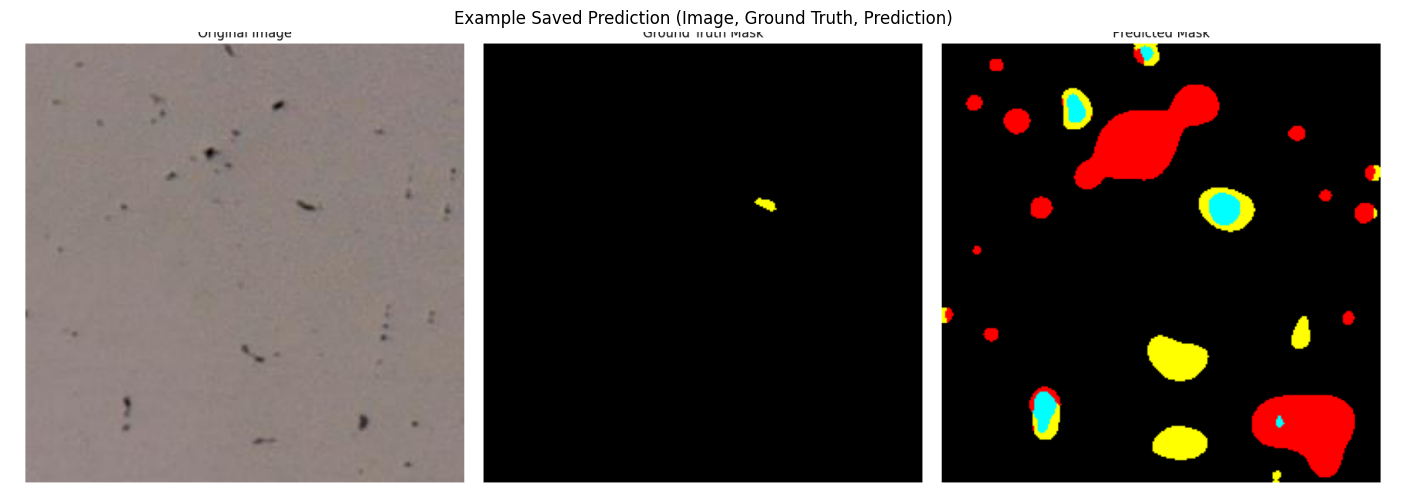

In [ ]:
try:
    first_prediction = cv2.imread('./test_predictions/prediction_0.png')
    first_prediction = cv2.cvtColor(first_prediction, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18,6))
    plt.imshow(first_prediction)
    plt.axis('off')
    plt.title("Example Saved Prediction (Image, Ground Truth, Prediction)")
    plt.show()
except Exception as e:
    print(f"Could not display example image. Error: {e}")